In [17]:
# Import libraries yang diperlukan
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [11]:
import pandas as pd
# Load dataset
file_path = '/content/Cleaned_dataset_new.csv'
df = pd.read_csv(file_path)

In [12]:
df

,sentiment,sentiment_label,Cleaned_Tweet
0,negative,0,disaat semua cowok berusaha melacak perhatian ...
1,neutral,1,rt siapa yang telat ngasih tau eluedan sarap...
2,neutral,1,41 kadang aku berfikir kenapa aku tetap percay...
3,negative,0,aku itu akunnku tau matamu sipit tapi diliat d...
4,negative,0,kaum cebong kapir udah keliatan dongoknya dari...
...,...,...,...
13164,neutral,1,jangan asal ngomong ndasmu congor lu yg sekate...
13165,negative,0,kasur mana enak kunyuk
13166,negative,0,hati hati bisu gnnlagi bosan huft xf0x9fx98xaa
13167,neutral,1,bom yang real mudah terdeteksi bom yang terkub...


EKSPLORASI DATA

In [40]:
df.info()
df.dropna()
# Cek apakah ada NaN di kolom Tweet
df['Cleaned_Tweet'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        13169 non-null  object
 1   sentiment_label  13169 non-null  int64 
 2   Cleaned_Tweet    13169 non-null  object
 3   Tweet_length     13169 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 411.7+ KB


0

<ipython-input-13-b4a66a4b8c98>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


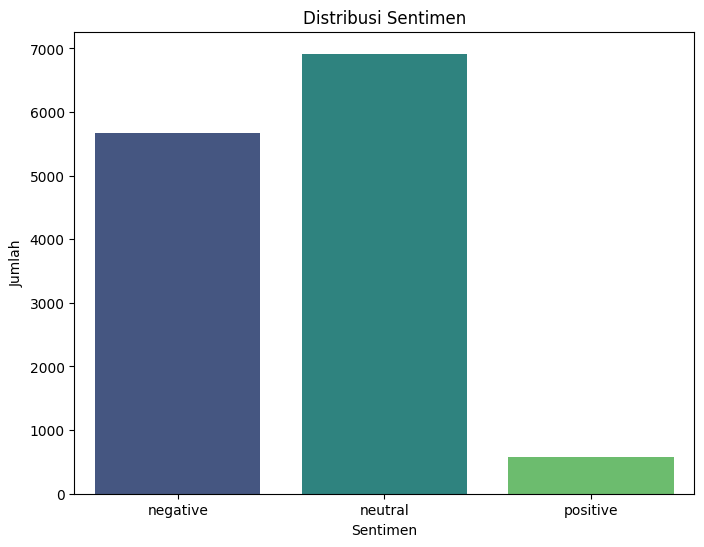

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi sentimen dengan label positif, negatif, dan netral
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()


In [14]:
# Menampilkan jumlah real dari setiap label sentimen
label_counts = df['sentiment'].value_counts()
print("Jumlah sampel per label sentimen:")
for label, count in label_counts.items():
    print(f"{label}: {count} sampel")

Jumlah sampel per label sentimen:
neutral: 6917 sampel
negative: 5669 sampel
positive: 583 sampel


In [20]:
# Perbaiki kolom 'Tweet'
df['Cleaned_Tweet'] = df['Cleaned_Tweet'].fillna('').astype(str)

# Tambahkan kolom panjang tweet
df['Tweet_length'] = df['Cleaned_Tweet'].apply(lambda x: len(x.split()))

       Cleaned_Tweet sentiment
count          13169     13169
unique         12931         3
top                    neutral
freq              41      6917


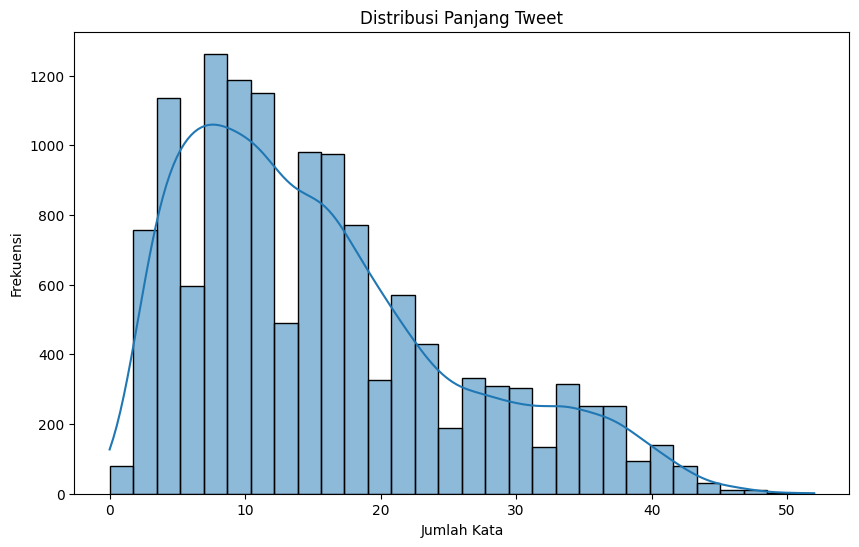

In [25]:
# Menampilkan statistik deskriptif dari kolom 'Tweet' dan 'sentiment'
print(df[['Cleaned_Tweet', 'sentiment']].describe())

# Menampilkan distribusi panjang tweet dalam dataset (jumlah kata per tweet)
df['Tweet_length'] = df['Cleaned_Tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['Tweet_length'], kde=True, bins=30)
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()



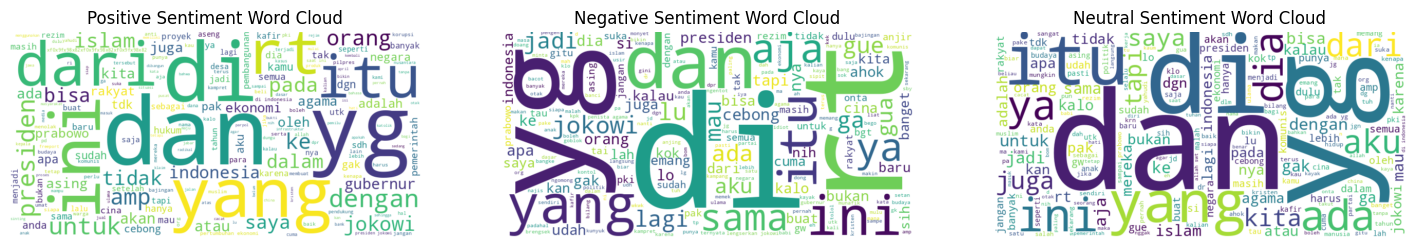

In [26]:
# Visualisasi word cloud untuk tweet dengan sentimen positif, negatif, dan netral
from wordcloud import WordCloud

# Filter tweet berdasarkan sentimen
positive_tweet = df[df['sentiment'] == 'positive']['Cleaned_Tweet']
negative_tweet = df[df['sentiment'] == 'negative']['Cleaned_Tweet']
neutral_tweet = df[df['sentiment'] == 'neutral']['Cleaned_Tweet']

# Membuat wordcloud untuk setiap sentimen
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweet))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweet))
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_tweet))

# Plot wordcloud
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(132)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.subplot(133)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')

plt.show()

Logistic Regression

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
le = LabelEncoder()

# Label encoding untuk kolom sentimen
df['sentiment_label'] = le.fit_transform(df['sentiment'])

# Pastikan semua data Tweet adalah string
df['Tweet'] = df['Cleaned_Tweet'].fillna('')

# Split data menjadi training dan testing
X = df['Tweet']  # Menggunakan kolom 'Tweet' sebagai fitur
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pastikan X_train dan X_test berisi teks yang valid
assert X_train.apply(lambda x: isinstance(x, str)).all(), "X_train contains non-string values!"
assert X_test.apply(lambda x: isinstance(x, str)).all(), "X_test contains non-string values!"

# Menggunakan TF-IDF untuk vektorisasi hanya pada teks (Tweet)
tfidf = TfidfVectorizer(max_features=5000)

# Vektorisasi data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Cek hasil vektorisasi
print(X_train_tfidf.shape)

# Model Logistic Regression
model = LogisticRegression(max_iter=1000)

# Latih model dengan data yang sudah tervektorisasi
model.fit(X_train_tfidf, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test_tfidf)




(10535, 5000)


In [43]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

# Menampilkan hasil dalam persen
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 70.24%
Precision: 66.96%
Recall: 70.24%
F1 Score: 68.53%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
# Menampilkan classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    negative       0.68      0.68      0.68      1103
     neutral       0.72      0.78      0.75      1411
    positive       0.00      0.00      0.00       120

    accuracy                           0.70      2634
   macro avg       0.47      0.49      0.48      2634
weighted avg       0.67      0.70      0.69      2634



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


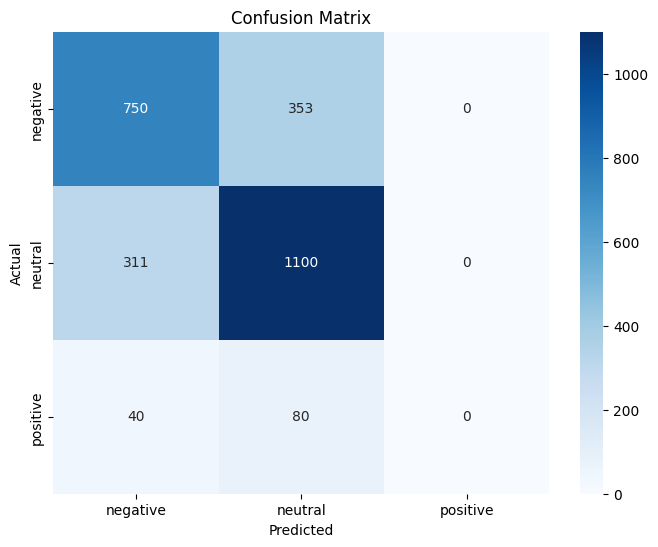

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()